# LMMMの簡単なデモ

基本的には[Simple end to end demo](https://github.com/google/lightweight_mmm/blob/main/examples/simple_end_to_end_demo.ipynb)に則っただけなので難しい点は特にないはず。

## 実行環境のセットアップ

まず必要なパッケージをインポートする。NumPyroはJAXベースなので、jax.numpyとnumpyroのインポートが必要。

In [1]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro

続いてLMMMの各モジュールをインポートする。この辺は単純にデモに従う。

In [2]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

## ダミーデータの準備

utilsにダミーデータ生成関数があるのでこれを使う。

In [3]:
SEED = 71

デフォルトではLMMMはweekly datasetを想定している。ここでは2年分＋1四半期（OOS用）を生成する。メディア変数は5個、非メディア変数（例えば競合他社の出稿状況など）は1個とする。

In [4]:
data_size = 104 + 13
n_media_channels = 5
n_extra_features = 1

ダミーデータを生成する。なおutils.simulate_dummy_dataはweekly以外は指定できないので注意。

In [5]:
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=data_size,
    n_media_channels=n_media_channels,
    n_extra_features=n_extra_features)

ダミーデータをtrain + OOSに分ける。メディア変数、非メディア変数、目的変数のそれぞれ別々に分ける必要がある。

In [6]:
# Split and scale data.
split_point = data_size - 13
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

スケーリング処理をかける。ROAS (ROI)や予算配分最適化の際は別立ての処理を行うので、ここでスケーリングしても大丈夫。

In [7]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

## モデル推定

ここからMCMCサンプリングによるモデル推定（パラメータ事後分布のサンプリング）を行っていく。

モデルの定義を行う。

In [8]:
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

MCMCサンプリングのwarmup / sampleそれぞれのサイズを決める。

In [9]:
number_warmup=1000
number_samples=1000

MCMCサンプリングを行う。これまでに設定した変数とハイパーパラメータを与えるだけで良い。

In [10]:
# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED)

/Users/ozakitakashi/Documents/tech/Python/notebooks/py3.7/lib/python3.7/site-packages/lightweight_mmm/lightweight_mmm.py:256: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  num_chains=number_chains)
sample: 100%|██████████| 2000/2000 [03:14<00:00, 10.30it/s, 459 steps of size 1.47e-03. acc. prob=0.92] 


## モデルのチェック

MCMCサンプリングの収束状況などを見る。

パラメータ推定のsummaryを見る。r_hatに注意（1.00近傍にあれば良い：1.1より大きいものは要検討）。

In [11]:
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.45      0.29      0.43      0.01      0.87    233.79      1.01
ad_effect_retention_rate[1]      0.29      0.15      0.28      0.03      0.52    310.06      1.00
ad_effect_retention_rate[2]      0.47      0.29      0.46      0.00      0.88    215.94      1.01
ad_effect_retention_rate[3]      0.44      0.28      0.41      0.00      0.84    462.27      1.01
ad_effect_retention_rate[4]      0.34      0.24      0.30      0.00      0.71    198.97      1.01
     coef_extra_features[0]      0.01      0.01      0.01     -0.01      0.02    234.48      1.02
              coef_media[0]      0.02      0.02      0.01      0.00      0.04    281.16      1.00
              coef_media[1]      0.15      0.03      0.15      0.10      0.21    249.11      1.01
              coef_media[2]      0.01      0.01      0.01      0.00      0.03    317.32      1.01
              coef_

パラメータの事後分布の密度分布を見る。「広告には原則として非負の効果がある」と仮定するMMMなのでメディア変数は切断分布になっていることが多い点に留意。

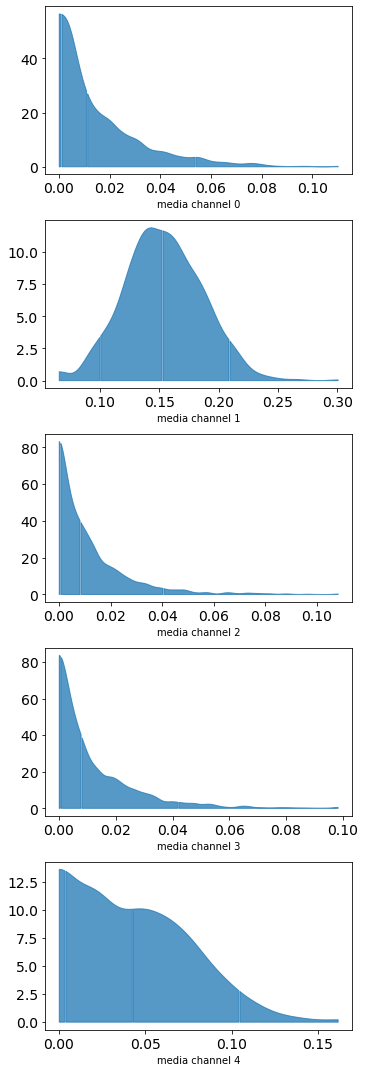

In [12]:
plot.plot_media_channel_posteriors(media_mix_model=mmm)

モデルの当てはまりを見る。単に時系列プロットを並べるだけ。

In [13]:
# Here is another example where we can pass the target scaler if you want the plot to be in the "not scaled scale"

## Due to version conflict, not shown...
# plot.plot_model_fit(mmm, target_scaler=target_scaler)

## モデル性能のチェック

OOSへの当てはまりから汎化性能の良し悪しをチェックする。本来ならここでは複数モデルの比較を行うべき。

In [14]:
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)
new_predictions.shape

(2000, 13)

In [15]:
## Due to version conflict, not shown...
# plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
#                                  out_of_sample_target=target_scaler.transform(target[split_point:]))

## メディア変数ごとの知見

ここからはモデルの「解釈」パート。メディア変数ごとの目的変数の寄与度や、ROAS (ROI)などを見る。

メディア変数の寄与度を見る。まずmmm.get_posterior_metricsで寄与度を算出し、プロットする。

In [16]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

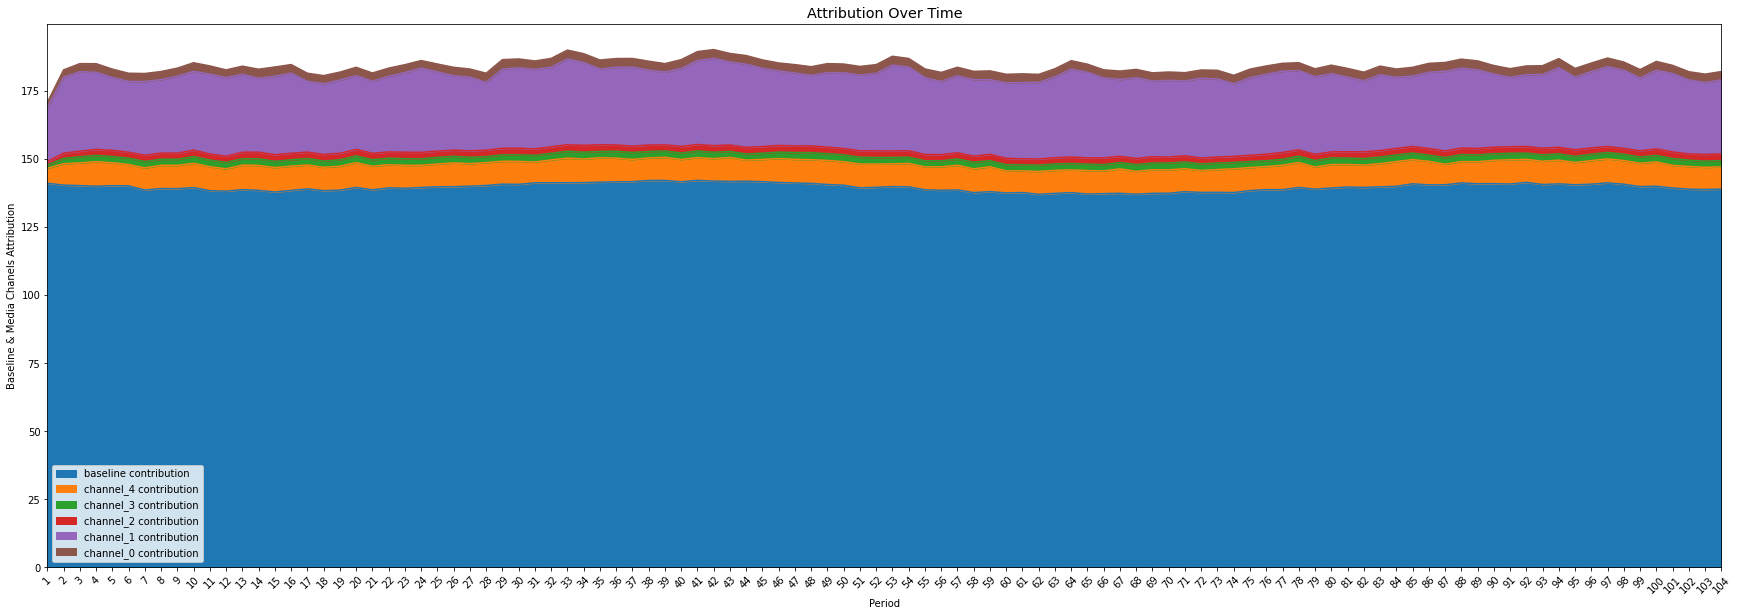

In [17]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

メディア変数ごとの期間にまたがるトータルの寄与度を見る。

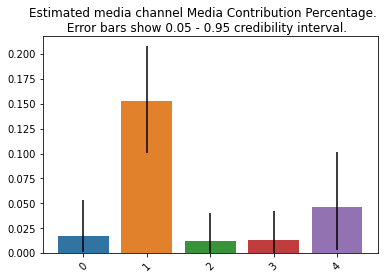

In [18]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")

メディア変数のROAS (ROI)をプロットする。

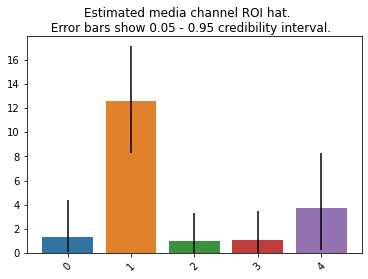

In [19]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")

メディア変数ごとのresponse curve（飽和度曲線）をプロットする。実際には対数関数に似た形状を示すことが多い。

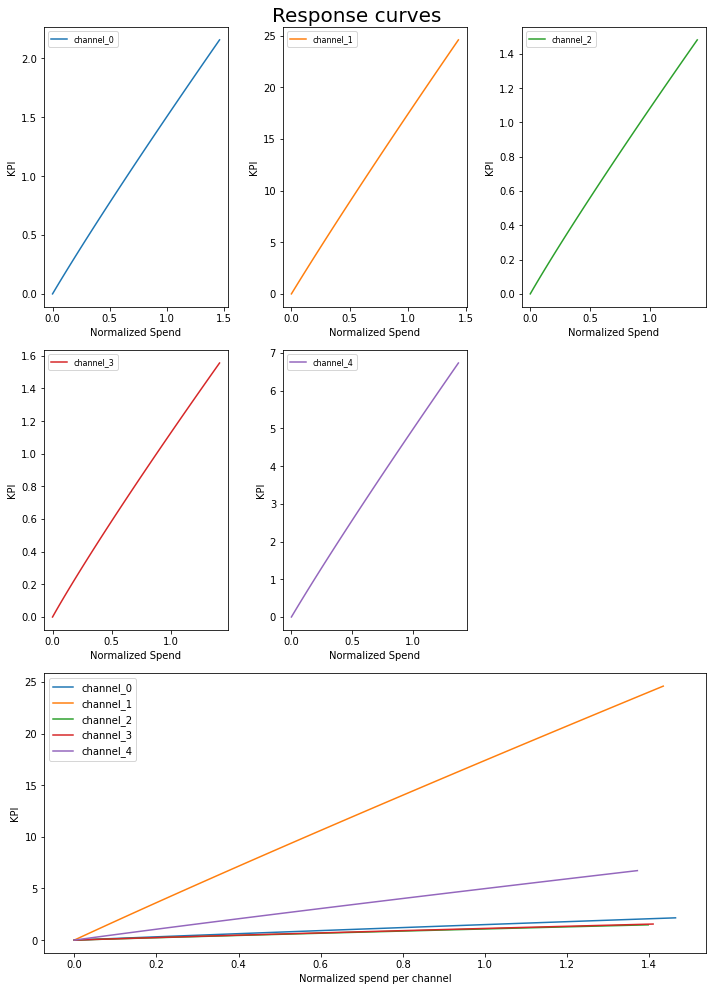

In [20]:
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

## 予算配分の最適化

最後に、最適化計画を解くことでメディア変数への最適な予算配分を求める。

最適化計画のためのサブデータセットを作る。

In [21]:
prices = jnp.ones(mmm.n_media_channels)

In [22]:
n_time_periods = 10
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

最適化計画を解く。

In [23]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_budget_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1936.8837435562587
            Iterations: 19
            Function evaluations: 114
            Gradient evaluations: 19


得られた解に基づいて、最適予算配分を求める。

In [24]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

DeviceArray([174.7285 , 285.152  , 132.38376, 128.85909, 276.38788], dtype=float32)

チェックとして、元の予算総額と最適配分時の予算総額がほぼ等しくなるかどうかを見る。

In [25]:
# Both values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(DeviceArray(997.5112, dtype=float32), DeviceArray(997.5112, dtype=float32))

In [26]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(DeviceArray(997.5112, dtype=float32), DeviceArray(997.5112, dtype=float32))

オリジナルの予算配分と、最適化された予算配分とを、それぞれ並べてプロットする。最適予算配分によって目的変数がどれくらいプラスされるかも見ることができる。

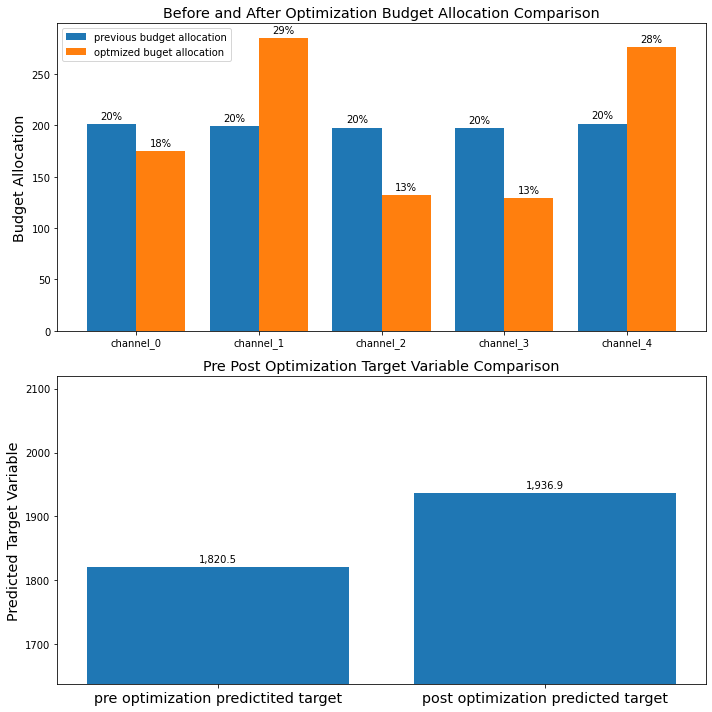

In [27]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10))

必要に応じてモデルはsave / loadできる。

In [28]:
# We can use the utilities for saving models to disk.
file_path = "media_mix_model.pkl"
utils.save_model(media_mix_model=mmm, file_path=file_path)

In [29]:
# Once saved one can load the models.
loaded_mmm = utils.load_model(file_path="media_mix_model.pkl")
loaded_mmm.trace["coef_media"].shape # Example of accessing any of the model values.

(2000, 5)